### A base model for LSTM (Rivanna GPU)
**Use Kernal PyTorch 1.4.0 Py3.7**  
parts are from **Neural Network Example**
(Authors: Brandon G. Jacques and Per B. Sederberg)

Here we simply drop in an LSTM module for the temporal representation. Given that it basically has a hidden layer built into it, we do not add in the extra linear layer like we did for the buffer and SITH models, however, you'll see below that it still ends up with twice as many weights to learn.

In [1]:
#! pip install --user mne

In [2]:
#!pip install --user seaborn

In [3]:
# currently use this as a work around for Rivanna
from SITH_Layer_master.sith import isith
from SITH_Layer_master.sith import deep_isith

In [4]:
# preprocessing
import mne
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

# pytorch
import torch
import torch.nn
import torch.nn.functional as F
ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
print(ttype)
labeltype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor

import matplotlib.pyplot as plt
%matplotlib inline

# training 
from torch import nn as nn
from math import factorial
import random
import seaborn as sn
import os 
from os.path import join
import glob


# deep_iSITH is being used here, not deep_sith
#from sith import DeepSITH
#from sith import iSITH 

from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")

# validation
from sklearn.metrics import roc_curve, auc, roc_auc_score, matthews_corrcoef

# load data
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
########


<class 'torch.cuda.DoubleTensor'>


#### GPU is available

In [5]:
torch.cuda.is_available()

True

## Prepare data

In [6]:

def creat_mne_raw_object(fname,read_events=True):
    """
    obtained from @author: alexandrebarachant
    https://www.kaggle.com/alexandrebarachant/beat-the-benchmark-0-67
    Create a mne raw instance from csv file.
    Make sure the events and data files are in the same folder
    data are transformed into microvolts
    """
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    #montage = make_standard_montage('standard_1005')

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)
    #info['filename'] = fname
    print(info)
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    #print(data)
    return raw

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>
34 events found
Event IDs: [1]


<ipython-input-6-29a39170704c>:35: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)


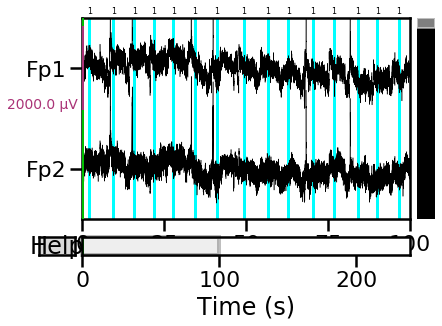

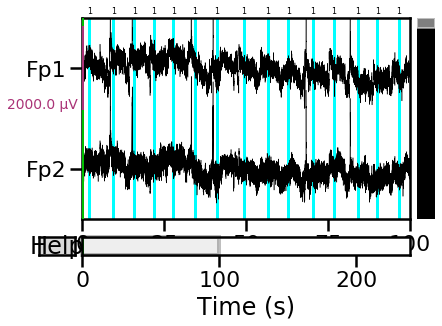

In [7]:
# testing
raw = creat_mne_raw_object("grasp-and-lift-eeg-detection/subj1_series1_data.csv")
# plotting 
# scaling is necessary to show the graphs properly
# vertical lines indicate a event
scalings = {'eeg': 10e-4}
events = mne.find_events(raw, stim_channel=['HandStart',])
raw.plot(n_channels=2,scalings=scalings,duration=100.0, events= events)

In [8]:

# input data, for this toy model, only consider the first 10000 unprocessed time points
## channels 32 to 38 are targets, for this model. Only predict one event a time

nClass = 5
data = raw.get_data()
input_signal = data[0:32,:]
print(input_signal.shape)
target_signal = target_signal_val =data[32+nClass-1,:] # use all six channels
print(target_signal.shape)

(32, 119496)
(119496,)


In [11]:
# reformatt into tensor with overlaps 
input_tensor = ttype(input_signal)


kernel_size = 1000
step = 900 # means 50 overlap --the step between each slice
patches_train = input_tensor.unfold(dimension = 1, size = kernel_size, step = step).permute(1,0,2)
print(patches_train.shape) # [B, C, nb_patches_h, nb_patches_w, kernel_size, kernel_size]


target_tensor = labeltype(target_signal)
patches_label = target_tensor.unfold(0, kernel_size, step)
print(patches_label.shape)



torch.Size([132, 32, 1000])
torch.Size([132, 1000])


In [216]:
# smapling for label
sampling_rate = 1
target_tensor = patches_label[:,::sampling_rate]
print(target_tensor.shape)


# sampling for training 
input_tensor = patches_train[:,:,::sampling_rate]
# reshape to have the secodn dimension as 1 to be compatible
# with deep_isith
input_tensor = input_tensor.unsqueeze(1)
print(input_tensor.shape)

torch.Size([125, 1000])
torch.Size([125, 1, 32, 1000])


In [217]:
# target label counts after down sampling
np.unique(target_tensor.detach().cpu().numpy(),return_counts=True)

(array([0, 1]), array([119877,   5123]))

In [218]:
percentage_training = 0.6
cut = int((input_tensor.shape[0])*percentage_training)
# for now, pick one batch as testing
train_X =  input_tensor[:cut,:,:,:]
train_Y = target_tensor[:cut,:]
test_X =  input_tensor[cut:,:,:,:]
test_Y = target_tensor[cut:,:]
print(train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)

torch.Size([75, 1, 32, 1000]) torch.Size([75, 1000]) torch.Size([50, 1, 32, 1000]) torch.Size([50, 1000])


In [219]:
test_Y.dtype

torch.int64

## LSTM Layer

In [220]:
class LSTM_EEG(torch.nn.Module):

    def __init__(self, in_features, hidden_dim, out_feuture, num_layers, dropout):
        super(LSTM_EEG, self).__init__()
        
        self.hidden_dim = hidden_dim

        self.lstm = torch.nn.LSTM( in_features,hidden_dim,num_layers =num_layers, 
                                  batch_first=True, dropout = dropout)

        # The linear layer that maps from hidden state space to output space
        self.fc = torch.nn.Linear(hidden_dim, out_feuture)

    def forward(self, inp):
        # input of shape (batch_size, nSequence, inputFeuture_size)
        # will be like [1, 6000, 32]
        inp_reshape = inp.squeeze(1).permute(0,2,1).float()
        #print(inp_reshape.shape)
        lstm_out, _ = self.lstm(inp_reshape)
        

        out_space = self.fc(lstm_out)
        #print(out_space.shape)

        return out_space

In [221]:
def train(model, ttype, train_sig, train_ans, 
          test_sig, test_ans, optimizer, loss_func, 
          epochs, loss_buffer_size=4, batch_size=1):
    assert(loss_buffer_size%batch_size==0)
    
    loss_track = {"name":[],
                  "loss":[],
                  "acc":[],
                  }

    # use this to keep track of progress
    progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
    #--------------------- Training --------------------#
    #iterate through epochs
    for e in progress_bar:

        model.train()
        optimizer.zero_grad()

        # make sure the out put is in the right format
        # needs to be in [nbatch x 1 x nfeutures x time]
        # unsqueeze(0) to add back the first dimension if necessary
        ## out = model(sig.unsqueeze(0))

        out = model(train_sig)
        # permute the out for cross entropy loss
        out = out.permute(0,2,1)
        #print(out.shape, train_ans.shape)
        loss = loss_func(out, train_ans)

        loss.backward()
        optimizer.step()

        #--- Record name, loss, validation accuracy --#
        loss_track['name'].append(model.__class__.__name__)
        loss_track['loss'].append(loss.mean().detach().cpu().numpy())

        # call test_model for validation accuracy calculations

        acc = test_model(model, test_sig,test_ans)
        loss_track['acc'].append(acc)
       
        # ----  update training progress -------------#

        # Update progress_bar
        s = "Epoch {},Loss: {:.8f}, Validation AUC:{} "
        format_list = [e, loss.mean().detach().cpu().numpy(), acc]         
        s = s.format(*format_list)
        progress_bar.set_description(s)

    return loss_track

def test_model(model, signal,target):
    """
    Test for accuracy for all batches
    Iterate through each batch and make prediciton and calculate performance metrics
    Use **matthews correlation coeefficient** since the data are imbanlanced
    Again 
    Signals need to be in correct format. validation input: [nbatch x 1 x nFeutures x time] tensor.

    The target has dimension of [time] tensor, in which each entry should be one of the numbers in 
    {0,1,2, ... K} at any time point.  
    
    """
    
    out_val = model(signal)
    #print(out_val.shape)
    # pass through a softmax to tansform to probability on the third dimention (nbatch, seq, outFeature)
    res = torch.nn.functional.softmax(out_val, dim=2)
    #print(res.shape)
    # predict should also be the second dimension [1] to clauclate AUC
    y_pred = res[:,:,1]

    # flatten the predicted result 
    y_score = np.ndarray.flatten(y_pred.detach().cpu().numpy())

    # flatten the predicted result 
    y_true = np.ndarray.flatten(target.detach().cpu().numpy())

    auc = roc_auc_score(y_true = y_true,y_score = y_score)

    #acc = matthews_corrcoef(y_true = y_true, y_pred = y_pred)

    return np.average(auc)


## training
The batch size has the same meaning as in the traditional feed forward models.
It stands for the number of sequences you want to process at the same time.  
Use Cuda

In [222]:
#nClass = 6
hidden_size = 50
# make sure this in_features matches the number of feutures in the EEG data
lstm_model = LSTM_EEG(in_features = train_X.shape[2], hidden_dim = hidden_size, 
                      out_feuture = 1+1,num_layers =2, dropout=0)

# map model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)


print(lstm_model)
tot = 0
for p in lstm_model.parameters():
    tot += p.numel()
print("tot_weights", tot)

LSTM_EEG(
  (lstm): LSTM(32, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)
tot_weights 37302


In [223]:
# start training
batch_size = 1
# num of epochs to train
nepochs = 1500
# leanring rate 
lr = 0.001


##### test with weighted cross entropy
# weighted cross entropy
weights = torch.cuda.FloatTensor([1,10])
print("weights:", weights)
loss_func =  torch.nn.CrossEntropyLoss(weight = weights,reduction='mean')
####

#loss_func =  torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lstm_model.parameters(),lr=lr)

weights: tensor([ 1., 10.], device='cuda:0')


In [224]:
perf = []
perf = train(lstm_model, ttype, train_X, train_Y, test_X, test_Y, 
                optimizer, loss_func, batch_size=batch_size,
                epochs=nepochs)


/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:22: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


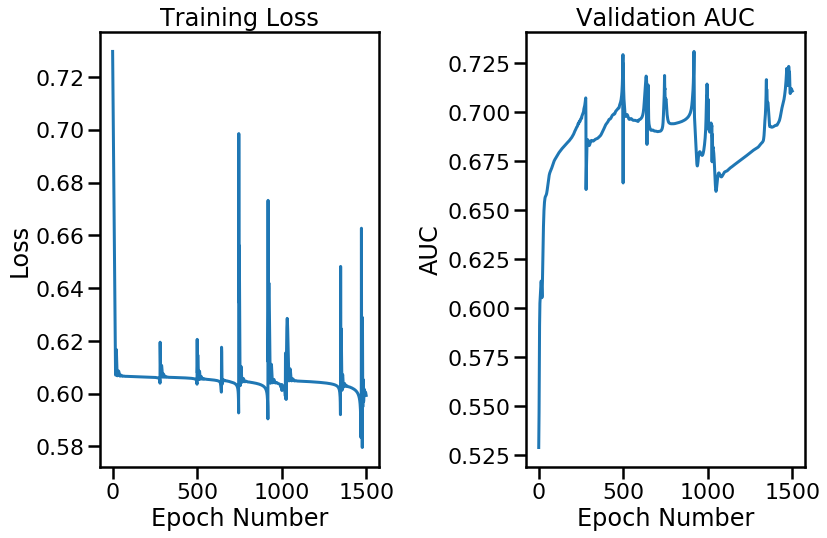

In [226]:
####    Plot training result
# build a dataframe
loss = np.array(perf['loss'])
acc = np.array(perf['acc'])
e = range(nepochs)
final_result = pd.DataFrame({'epoch' : e,'loss' : loss, 'accuracy' : acc}) 
final_result.head()
fig = plt.figure(figsize=(12, 8),constrained_layout=True)
ax = fig.add_subplot(121)
sn.lineplot(data=final_result, x='epoch', y='loss',
            ax=ax)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")

ax = fig.add_subplot(122)
sn.lineplot(data=final_result, x='epoch', y='accuracy',
            ax=ax)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("AUC")
ax.set_title("Validation AUC")
plt.tight_layout()
plt.show()

## Model evaluation

In [227]:
# reshape and flatten the test_Y
y_true = np.ndarray.flatten(test_Y.detach().cpu().numpy())

In [228]:
y_true.shape

(50000,)

In [229]:
# predict using test_X
out_val =lstm_model(test_X)

# pass through a softmax to tansform to probability
res = torch.nn.functional.softmax(out_val, dim=2)
y_pred = res[:,:,1]

# flatten the predicted result 
y_score = np.ndarray.flatten(y_pred.detach().cpu().numpy())

In [230]:
y_score.shape

(50000,)

In [231]:
roc_auc_score(y_true = y_true,y_score = y_score)

0.7108676269091219